In [1]:
## Importing all the necessary packages

%matplotlib inline
%pip install tensorflow numpy matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(tf.config.list_physical_devices('GPU'))

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


2023-08-25 13:32:21.896596: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 13:32:21.898572: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 13:32:21.936930: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 13:32:21.937734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 13:32:22.981941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

[]


2023-08-25 13:32:25.195649: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
## Sampling class to use the reparameterization technique: z_mean + z_var * N(0,1) --> Normal Distribution
## We train for log variance instead of variance because it brings stability and ease of use rather than training for variance directly.
## Please refer to link for explaination https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
## Defining the latent dimensions and the Encoder part of the VAE model

latent_dim = 3

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])


In [4]:
## Continue with outputs of the Encoder layer and input to the Decoder layer

x_1 = layers.Dense(7 * 7 * 64, activation="relu")(z)
x = layers.Reshape((7, 7, 64))(x_1)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

vae_m = keras.Model(inputs,decoder_outputs,name="vae")  ##combine encoder and decoder to create the VAE model
vae_m.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 7, 7, 64)             0         ['conv2d_1[0][0]']            
                                                                                                

In [5]:
##Seperating the VAE into encoder and decoder models. We do this because once we combine the CNN, we need to split the VAE + CNN model at the latent sampling layer
## which is the output of the encoder.

layer_names = ['z_mean','z_log_var','sampling']
encoder_model = keras.Model(inputs=vae_m.input,
                                 outputs=[vae_m.get_layer(layer).output for layer in layer_names],name="encoder")
encoder_model.summary()
decoder_model = keras.Model(inputs=vae_m.get_layer(layer_names[2]).output,
                                 outputs=vae_m.output, name="decoder")
decoder_model.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 7, 7, 64)             0         ['conv2d_1[0][0]']            
                                                                                            

In [6]:
#Added a classifier layer attempt for better latent space seperation of classes
""" STILL IN DEVELOPMENT """

clf_latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling_clf')
clf_inter = layers.Dense(10, activation='softmax', name='class_output')(clf_latent_inputs)
clf_inter = layers.BatchNormalization(synchronized=True)(clf_inter)
clf_outputs = layers.Dropout(0.8)(clf_inter)
clf_supervised = keras.Model(clf_latent_inputs, clf_outputs, name='clf')
clf_supervised.summary()

Model: "clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling_clf (InputLayer  [(None, 3)]               0         
 )                                                               
                                                                 
 class_output (Dense)        (None, 10)                40        
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
Total params: 80 (320.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable params: 20 (80.00 Byte)
_________________________________________________________________


In [15]:
## Defining the custom loss function: Total_loss = Image Reconstruction Loss + KL Divergence Loss + Classifier Layer Loss

class VAE(keras.Model):
    def __init__(self, encoder, decoder,classifier,y_train,batch_size, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self.y_input = y_train
        self.batch_size = batch_size
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.class_loss_tracker = keras.metrics.Mean(name="class_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.class_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
                
            z_mean, z_log_var, z = self.encoder(data)
            y_hat = self.classifier(z)
            
            y_train = np.random.choice(self.y_input,self.batch_size)
            reconstruction = self.decoder(z)

            #Image Reconstruction Loss
            reconstruction_loss = 10000*tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            #Classifier Loss 
            class_loss = 100*keras.losses.sparse_categorical_crossentropy(y_train,y_hat)

            #KL Divergence Loss

            kl_loss = (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = - 0.001*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + class_loss + kl_loss   #Final Loss calculation
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.class_loss_tracker.update_state(class_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "class_loss": self.class_loss_tracker.result(),
        }

In [16]:
## Preprocessing the dataset and training the model

(x_train, l_train), (x_test, l_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


mnist_labels = np.concatenate([l_train, l_test], axis=0)

batch = 10
vae = VAE(encoder_model, decoder_model, clf_supervised, mnist_labels,batch)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=2e-5))
vae.fit(mnist_digits, epochs=25, batch_size=batch)

Epoch 1/25
7000/7000 [==============================] - 51s 7ms/step - loss: 1769529.0211 - reconstruction_loss: 1761873.3750 - kl_loss: 634.3856 - class_loss: 230.0977
Epoch 2/25
7000/7000 [==============================] - 50s 7ms/step - loss: 1738730.3243 - reconstruction_loss: 1732876.8750 - kl_loss: 544.8297 - class_loss: 203.3126
Epoch 3/25
7000/7000 [==============================] - 49s 7ms/step - loss: 1714139.3646 - reconstruction_loss: 1706608.5000 - kl_loss: 442.2414 - class_loss: 191.3790
Epoch 4/25
7000/7000 [==============================] - 49s 7ms/step - loss: 1689672.8656 - reconstruction_loss: 1681465.5000 - kl_loss: 355.3318 - class_loss: 186.9797
Epoch 5/25
7000/7000 [==============================] - 49s 7ms/step - loss: 1659897.7124 - reconstruction_loss: 1652116.3750 - kl_loss: 263.6339 - class_loss: 183.4113
Epoch 6/25
7000/7000 [==============================] - 49s 7ms/step - loss: 1629010.0200 - reconstruction_loss: 1621369.7500 - kl_loss: 186.6084 - class_l

In [9]:

# def plot_latent_space(vae, n=30, figsize=15):
#     # display an n*n 2D manifold of digits
#     digit_size = 28
#     scale = 1.0
#     figure = np.zeros((digit_size * n, digit_size * n))
#     # linearly spaced coordinates corresponding to the 2D plot
#     # of digit classes in the latent space
#     grid_x = np.linspace(-scale, scale, n)
#     grid_y = np.linspace(-scale, scale, n)[::-1]

#     for i, yi in enumerate(grid_y):
#         for j, xi in enumerate(grid_x):
#             z_sample = np.array([[xi, yi]])
#             x_decoded = vae.decoder.predict(z_sample)
#             digit = x_decoded[0].reshape(digit_size, digit_size)
#             figure[
#                 i * digit_size : (i + 1) * digit_size,
#                 j * digit_size : (j + 1) * digit_size,
#             ] = digit

#     plt.figure(figsize=(figsize, figsize))
#     start_range = digit_size // 2
#     end_range = n * digit_size + start_range
#     pixel_range = np.arange(start_range, end_range, digit_size)
#     sample_range_x = np.round(grid_x, 1)
#     sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.imshow(figure, cmap="Greys_r")
#     plt.show()


# plot_latent_space(vae)

In [17]:
## Calculating the 95% confidence level bounds to remove abberant samples in latent space over 2 std_error values from each of the mean values.
## For n -> latent space dimension and c -> classes we shall have (n x c) -> std_mean and std_variance values and (n x c x 2) -> 95% confidence bounds.
""" STILL IN DEVELOPMENT """

from operator import itemgetter
from itertools import groupby
import scipy.stats as st
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

_,_,z = encoder_model.predict(x_test)
l = zip(z,y_test)
sort_list = sorted(l,key = itemgetter(1))
#print(sort_list)
sorted_list = []
sorting_list = []
bounds_95 = ()
for i in range(9):
    sorted_list = [values for values,key in sort_list if key == i]
    #print(sorted_list)
    sorted_list.append(sorting_list)
    bounds_95 += st.t.interval(alpha=0.95, df=len(sorted_list)-1, loc=np.mean(sorted_list[i]), scale = st.sem(sorted_list[i])) + (i,)
    print(bounds_95)
    


313/313 [==============================] - 1s 2ms/step
(-4.935844051256289, 60.430442439928164, 0)
(-4.935844051256289, 60.430442439928164, 0, 0.8455674420537704, 85.6479323138056, 1)
(-4.935844051256289, 60.430442439928164, 0, 0.8455674420537704, 85.6479323138056, 1, -11.313024388433114, 56.561296330571786, 2)
(-4.935844051256289, 60.430442439928164, 0, 0.8455674420537704, 85.6479323138056, 1, -11.313024388433114, 56.561296330571786, 2, -0.9931861506329334, 54.68527904614075, 3)
(-4.935844051256289, 60.430442439928164, 0, 0.8455674420537704, 85.6479323138056, 1, -11.313024388433114, 56.561296330571786, 2, -0.9931861506329334, 54.68527904614075, 3, -20.381094338921308, 39.983692529228925, 4)
(-4.935844051256289, 60.430442439928164, 0, 0.8455674420537704, 85.6479323138056, 1, -11.313024388433114, 56.561296330571786, 2, -0.9931861506329334, 54.68527904614075, 3, -20.381094338921308, 39.983692529228925, 4, -12.644076531328757, 45.86669844905337, 5)
(-4.935844051256289, 60.430442439928164,

1875/1875 [==============================] - 4s 2ms/step


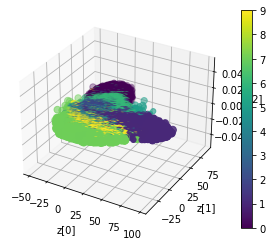

In [18]:
## 3D plotting of any 3 dimensions out of the available n latent spaces available
""" STILL IN DEVELOPMENT for better plotting methods """


def plot_cluster_3D(vae, data, labels):
    # display a 3D plot of the digit classes in the latent space
    _, _, z_mean = vae.encoder.predict(data)
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    p = plt.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:,2], c=labels)
    fig.colorbar(p)
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.set_zlabel("z[2]")
    plt.show()


(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_cluster_3D(vae, x_train, y_train)

1875/1875 [==============================] - 4s 2ms/step


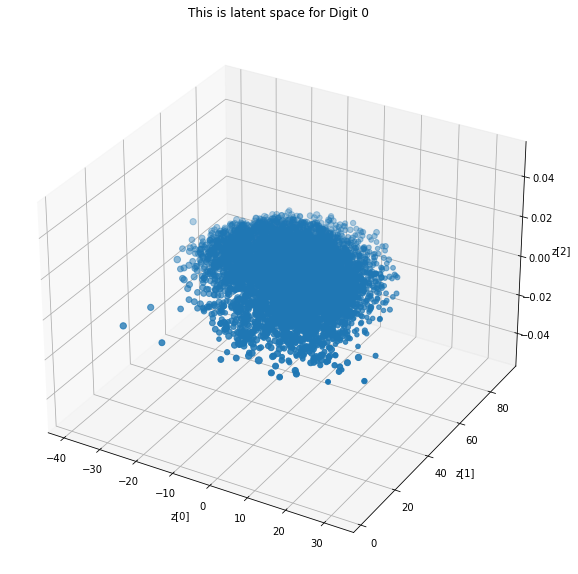

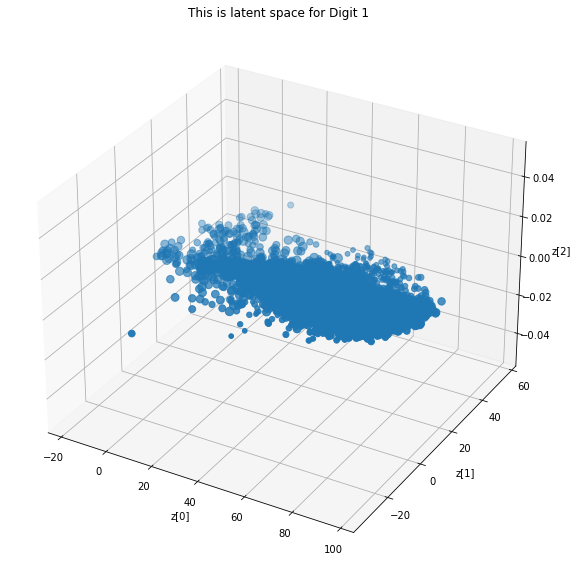

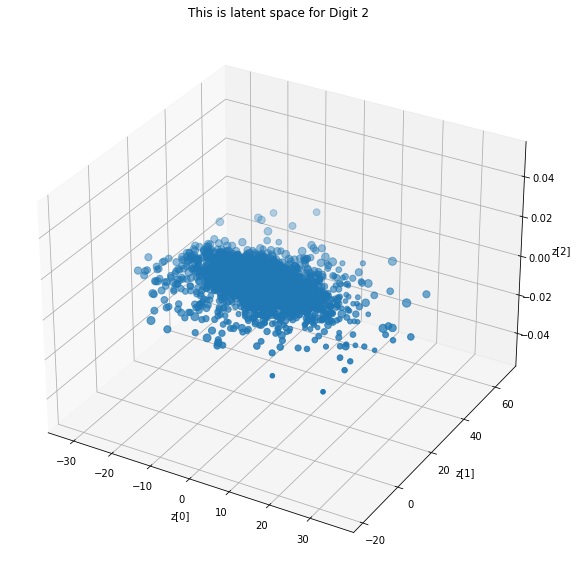

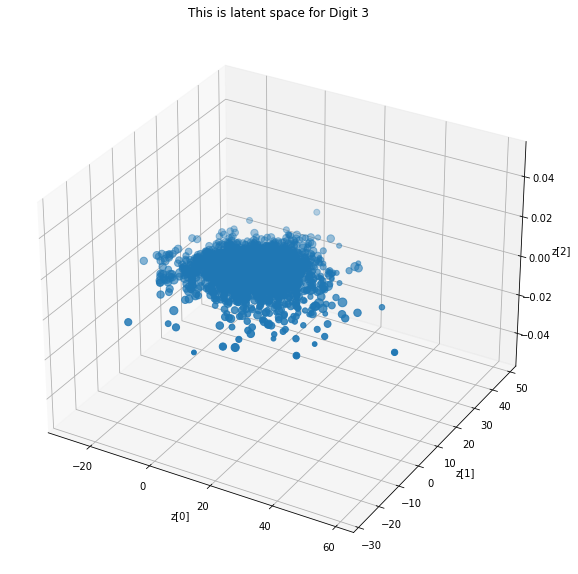

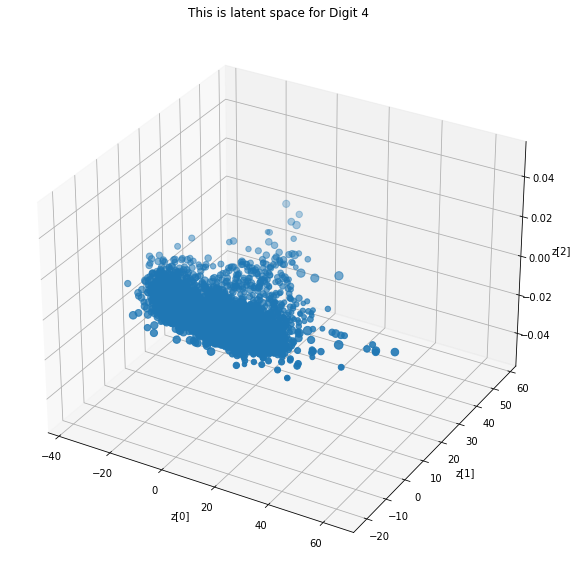

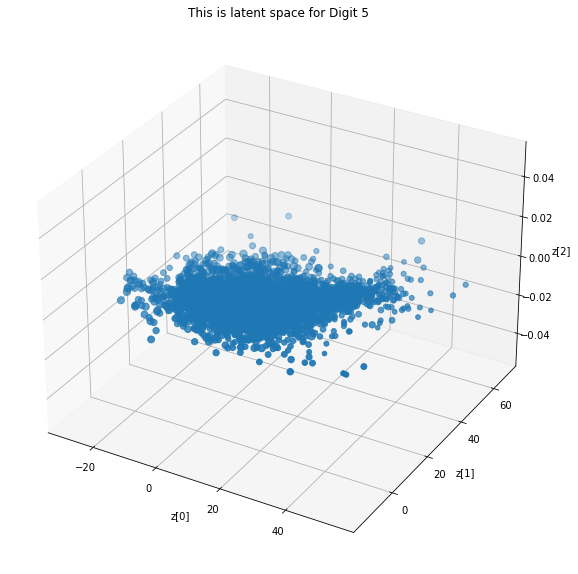

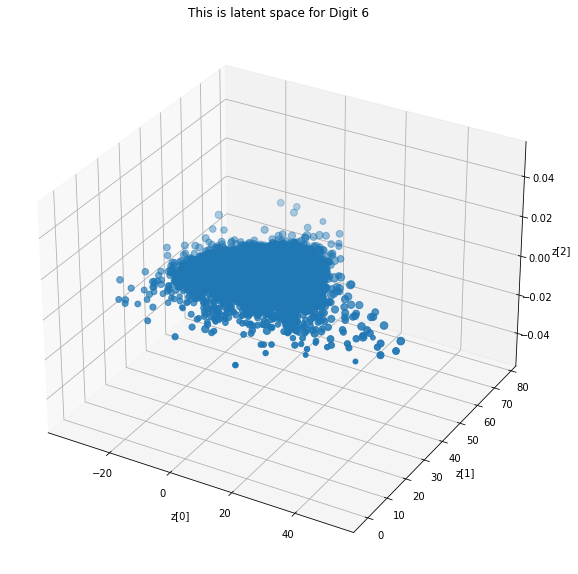

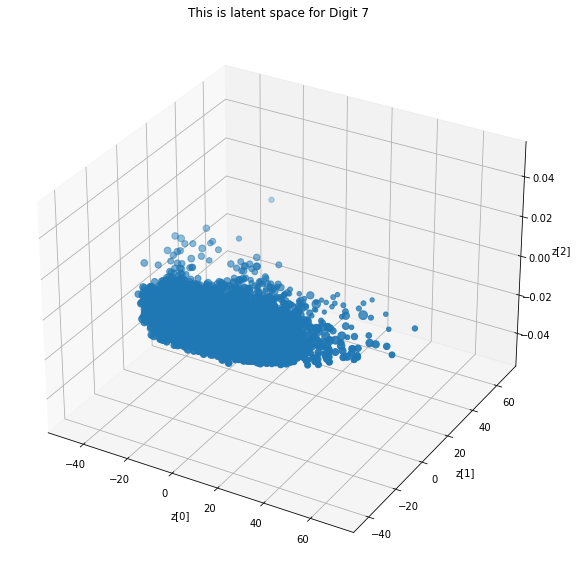

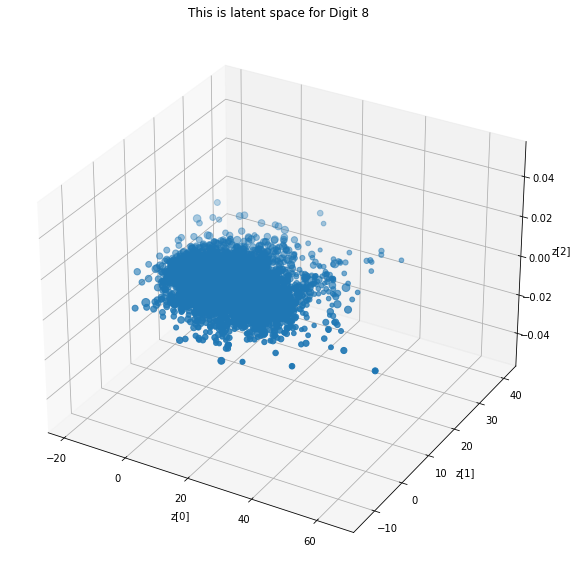

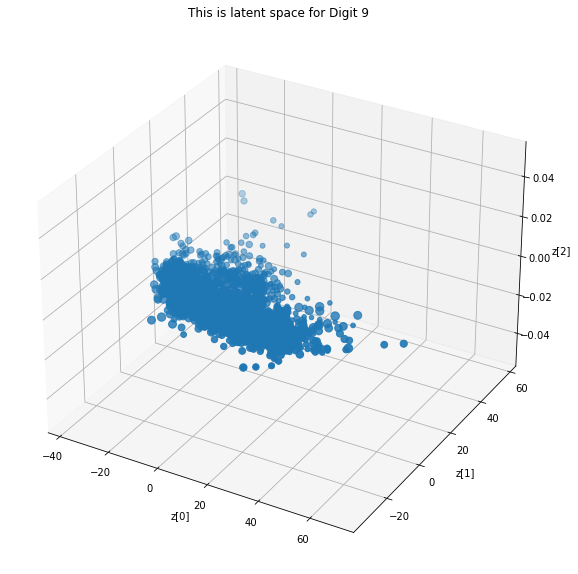

In [19]:
## Plot 3D clusters for each class individually

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from operator import itemgetter

def plot_class_cluster_3D(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    _,_,z = model.predict(data)
    l = zip(z,labels)
    sort_list = sorted(l,key = itemgetter(1))
    for i in range(10):
        sorted_list = [values for values,key in sort_list if key == i]
        sort_x = [item [0] for item in sorted_list]
        sort_y = [item [1] for item in sorted_list]
        sort_z = [item [2] for item in sorted_list]
        hull = ConvexHull(sorted_list)
        
        #for simplex in hull.simplices:
            #plt.plot(z[simplex,0],z[simplex,1],'k-')   
        #plt.colorbar()
        
        
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(projection="3d")
        plt.scatter(sort_x, sort_y, sort_z) 
        ax.set_xlabel("z[0]")
        ax.set_ylabel("z[1]")
        ax.set_zlabel("z[2]")
        plt.title("This is latent space for Digit " + str(i) )
        plt.show()


(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_class_cluster_3D(encoder_model, x_train, y_train)

##Ask question whether it makes sense to bound sample values or mean values

1875/1875 [==============================] - 4s 2ms/step


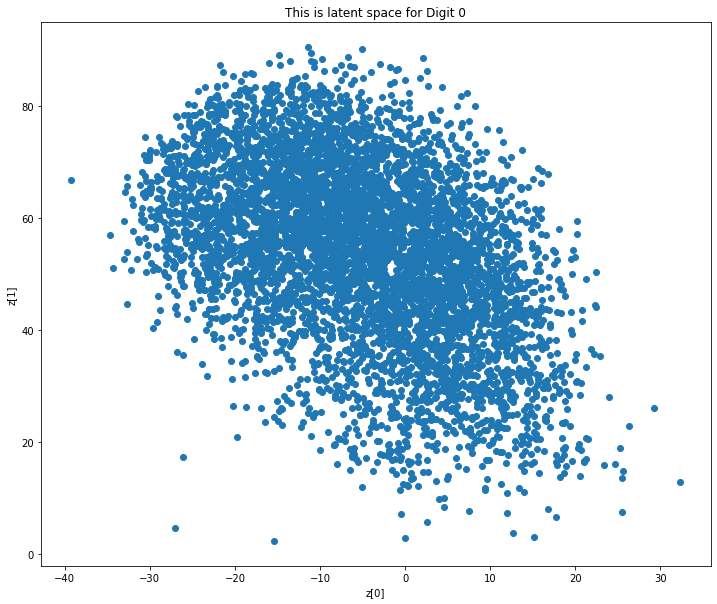

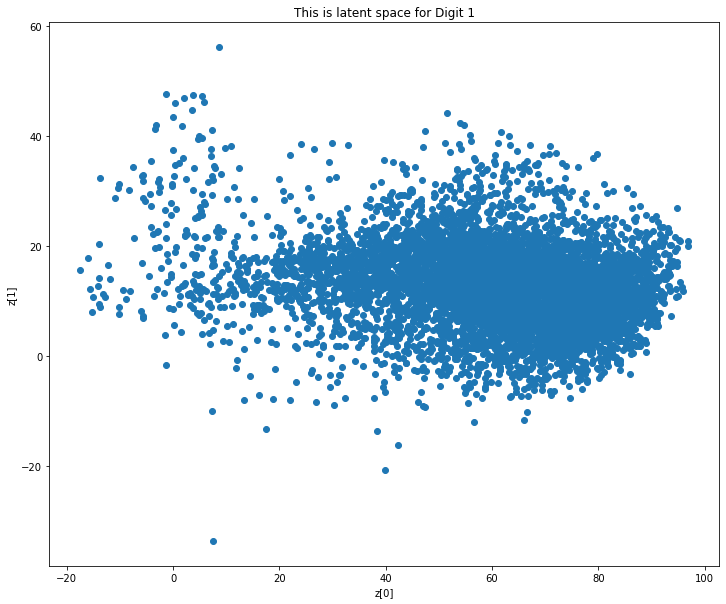

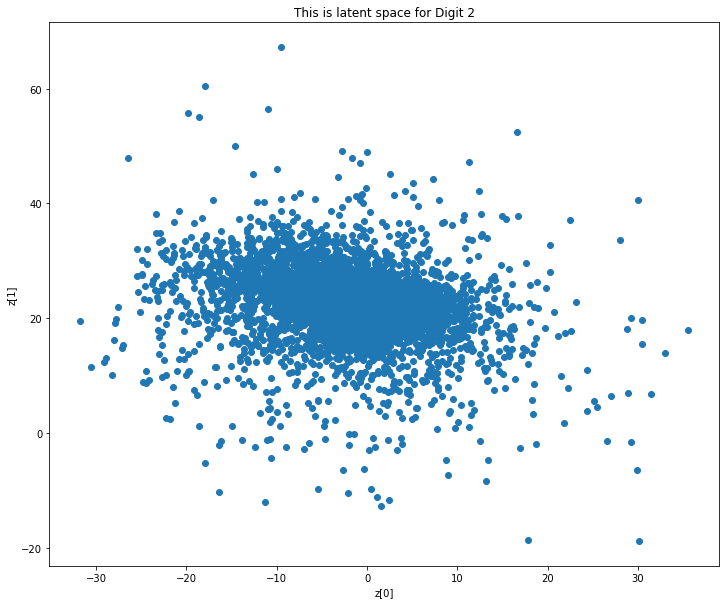

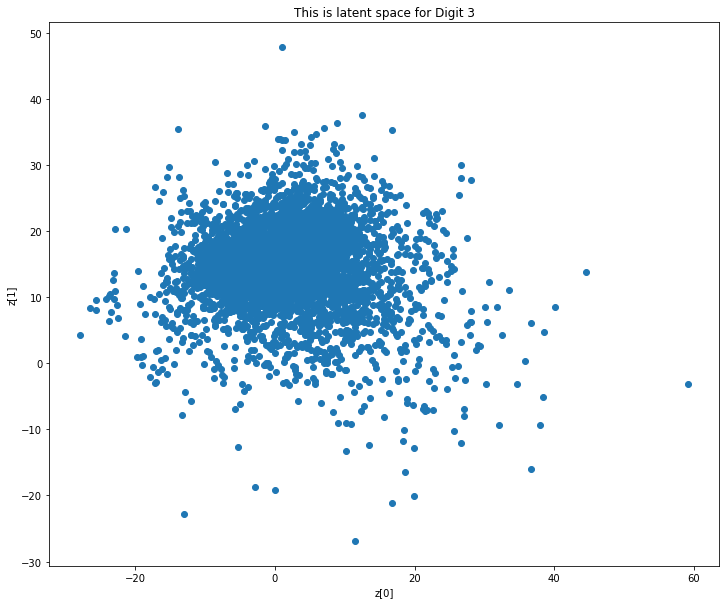

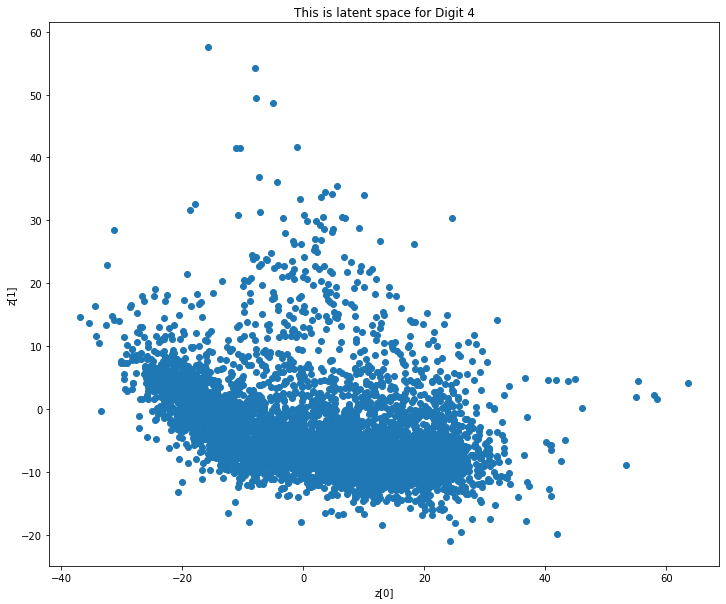

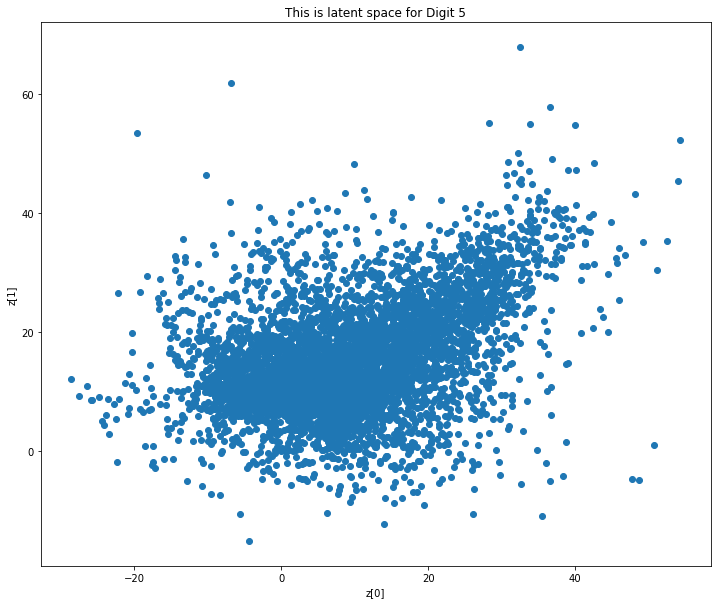

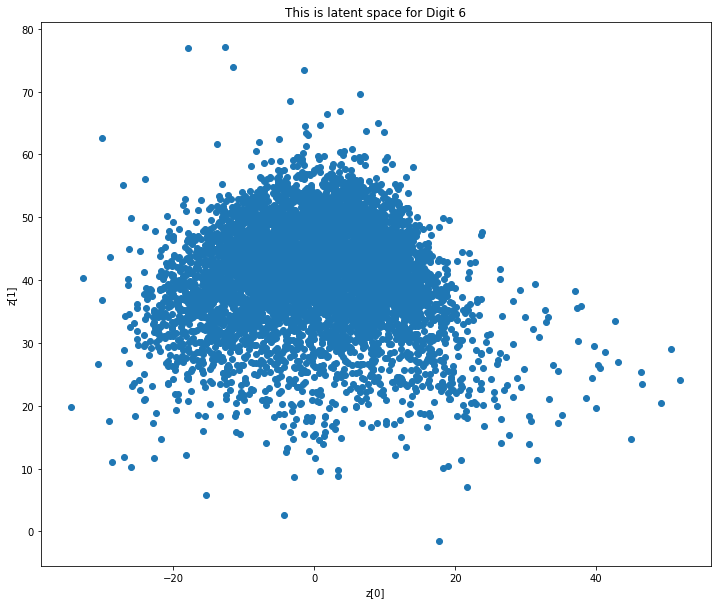

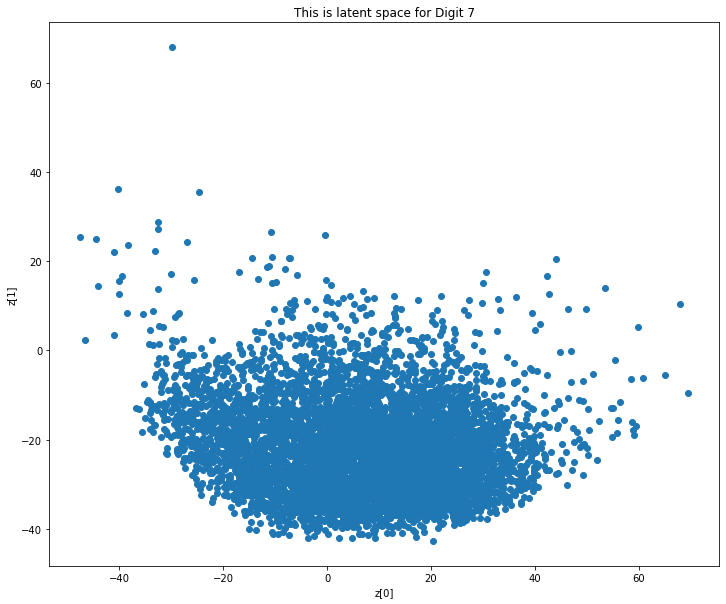

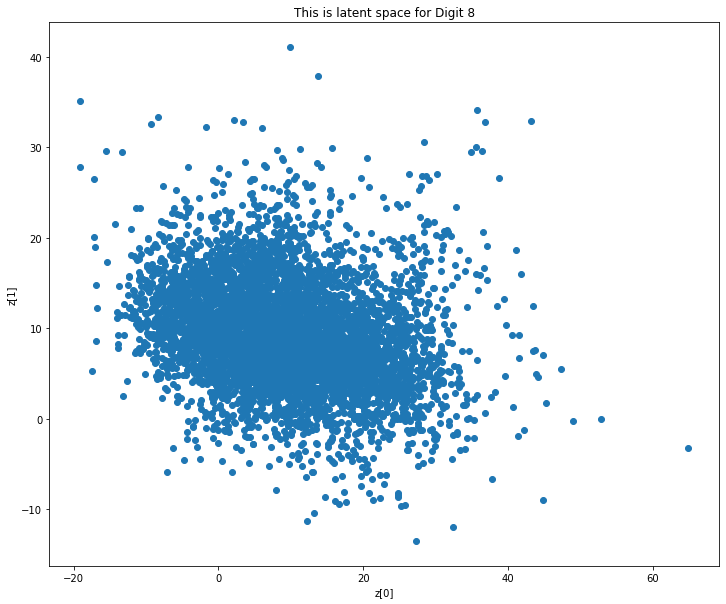

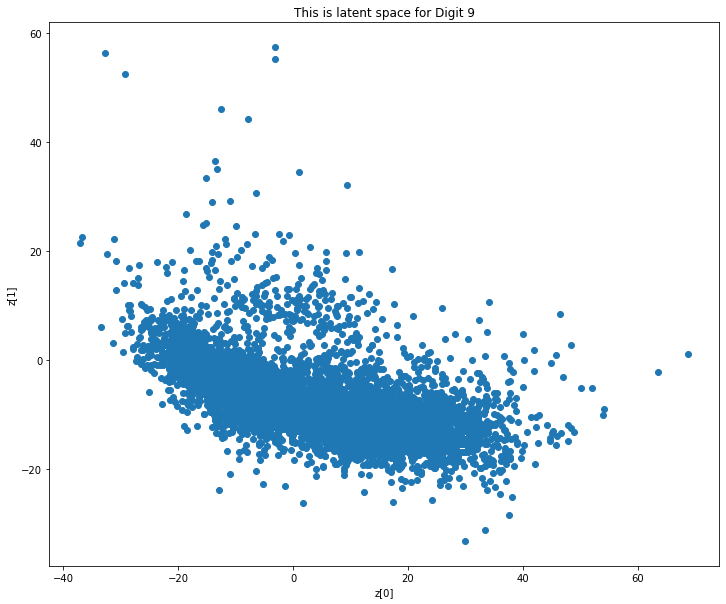

In [20]:
## Plot 2D class clusters in any 2 dimensions


def plot_class_clusters_2D(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    _,_,z = model.predict(data)
    l = zip(z,labels)
    sort_list = sorted(l,key = itemgetter(1))
    for i in range(10):
        sorted_list = [values for values,key in sort_list if key == i]
        sort_x = [item [0] for item in sorted_list]
        sort_y = [item [1] for item in sorted_list]
        hull = ConvexHull(sorted_list)
        
        #for simplex in hull.simplices:
            #plt.plot(z[simplex,0],z[simplex,1],'k-')   
        #plt.colorbar()
        
        
        plt.figure(figsize=(12, 10))
        plt.scatter(sort_x, sort_y) 
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.title("This is latent space for Digit " + str(i) )
        plt.show()


(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_class_clusters_2D(encoder_model, x_train, y_train)

##Ask question whether it makes sense to bound sample values or mean values

In [21]:
## Load a pre-trainined CNN model for the MNIST dataset
## This model is trained and saved using the MNIST.ipynb file


model_path = "models/MNIST_model"
m = tf.saved_model.load(model_path)
x_decoded = vae_m.predict(x_test)  #Recreating new images using the VAE model

313/313 [==============================] - 1s 4ms/step


This is the real label:7
This is the predicted label of the recreated image:9
This is the predicted label of the original image:9


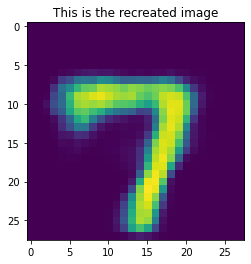

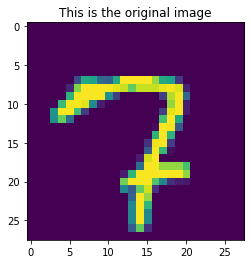

In [23]:
# load the CNN model and predict the class labels of the original image and recreated images from the VAE

index = 36
plt.figure(1)
plt.imshow(x_decoded[index])
plt.title("This is the recreated image")

plt.figure(2)
plt.imshow(x_test[index])
plt.title("This is the original image")
print("This is the real label:" + str(y_test[index]))

prediction_from_decoder = m(x_decoded)
print("This is the predicted label of the recreated image:" + str(y_test[np.argmax(prediction_from_decoder[index])]))

prediction_input_image = m(x_test)
print("This is the predicted label of the original image:" + str(y_test[np.argmax(prediction_input_image[index])]))

